# Deskripsi Proyek: Gold Recovery Model

Saatnya untuk berhadapan langsung dengan permasalahan data science yang sesungguhnya dari bidang pertambangan emas. Proyek ini difasilitasi oleh Zyfra.
Anda perlu untuk:
 - Mempersiapkan data yang tersedia;
 - Menjalankan analisis data;
 - Mengembangkan dan melatih model.

Untuk menyelesaikan proyek ini, Anda akan perlu menggunakan dokumentasi dari library Pandas, Matplotlib, dan Sklearn.
Pelajaran selanjutnya akan membahas tentang proses pemurnian bijih emas. Anda akan menentukan informasi yang sekiranya dibutuhkan untuk mengembangkan model Anda.


## Tujuan Proyek
- Menyiapkan sebuah prototipe model machine learning untuk Zyfra. Perusahaan ini bergerak di bidang pengembangan solusi efisien untuk industri berat.
- Membuat model yang bisa memprediksi jumlah emas yang diekstraksi atau diperoleh dari bijih emas. Dengan menggunakan data yang tersedia terkait proses ekstraksi dan pemurnian bijih emas.
- Model ini nantinya diharapkan akan membantu terciptanya proses produksi yang lebih efisien dan menyingkirkan parameter-parameter yang tidak menghasilkan keuntungan.

## Deskripsi Data
- Data yang Anda butuhkan tersimpan dalam tiga file:
    - `gold_recovery_train.csv` — unduh training dataset
    - `gold_recovery_test.csv` — unduh test dataset
    - `gold_recovery_full.csv` — unduh dataset sumber

- Kendala:
    - Data ini diindeks sesuai dengan tanggal dan waktu perolehannya (fitur date). 
    - Terkait waktu, parameter yang berdekatan sering kali serupa.
    - Sebagian parameter tidak tersedia karena pengukuran dan/atau penghitungannya dilakukan jauh setelahnya. Itulah sebabnya, beberapa fitur yang ada di training set mungkin tidak ada di test set. Test set-nya pun juga tidak memuat target.
    - Dataset sumber memuat training dan test set dengan semua fitur-fiturnya.
    - Anda memiliki data mentah yang baru saja diunduh dari gudang data. 
    - Sebelum membuat model, periksalah ketepatan datanya. Untuk itu, ikutilah instruksinya.

## Instruksi Proyek
- 1. Mempersiapkan datanya
    - 1.1. Buka file dan pelajari datanya.
      File path:
      - `/datasets/gold_recovery_train.csv`
      - `/datasets/gold_recovery_test.csv`
      - `/datasets/gold_recovery_full.csv`
     - 1.2. Periksa apakah perolehan emas telah dihitung dengan benar. Menggunakan training set, hitung perolehan untuk fitur rougher.output.recovery. Temukan MAE antara perhitungan Anda dan nilai fitur. Tunjukkan apa yang Anda temukan.
     - 1.3. Analisis fitur-fitur yang tidak tersedia pada test set.Apa saja parameter-parameter ini? Tipe apakah parameter-parameter tersebut?
     - 1.4. Lakukan pra-pemrosesan data.

- 2. Analisis datanya
    - 2.1. Buatlah catatan terkait bagaimana konsentrasi logam (Au, Ag, Pb) berubah, tergantung pada tahap pemurniannya.
    - 2.2. Bandingkan distribusi ukuran partikel umpan dalam training set maupun dalam test set. Jika distribusinya bervariasi secara signifikan, evaluasi model akan salah.
    - 2.3. Pertimbangkan total konsentrasi semua substansi di tahap yang berbeda: umpan (feed) mentah, konsentrasi yang lebih kasar, dan konsentrasi akhir. Apakah Anda melihat adanya nilai abnormal dalam distribusi total? Jika ya, apakah perlu menghapus nilai-nilai tersebut dari kedua sampel? Jelaskan yang Anda temukan dan singkirkan anomalinya.

- 3. Buat modelnya
    - 3.1. Ketiklah sebuah fungsi untuk menghitung nilai sMAPE akhir.
    - 3.2. Lakukan pelatihan pada model yang berbeda-beda. Evaluasi model-model tersebut menggunakan validasi silang. Pilihlah model terbaik dan uji model tersebut menggunakan sampel tes atau test sample. Tunjukkan apa yang Anda temukan.

In [1]:
# memuat semua library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import math
import itertools
from plotly.subplots import make_subplots
from scipy.stats import levene
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',100)

In [2]:
#import libraries

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

from sklearn.dummy import DummyClassifier

In [3]:
# membuat daftar untuk praproses, analisis data
stage = ['rougher.output.','primary_cleaner.output.','final.output.']
core = ["concentrate"]
metals = ['_au','_ag','_pb']

list_au = [stage,core,['_au']]
list_ag = [stage,core,['_ag']]
list_pb = [stage,core,['_pb']]
list_sol = [stage,core,['_sol']]

feed_au =['rougher.input.feed_au']
feed_ag =['rougher.input.feed_ag']
feed_pb = ['rougher.input.feed_pb']
feed_sol = ['rougher.input.feed_sol']

lists = [stage,core,metals]
concentrate_list  = ["".join(i) for i in itertools.product(*lists)]
all_list = concentrate_list + feed_au + feed_ag + feed_pb + feed_sol
concentrate_au_list = ["".join(i) for i in itertools.product(*list_au)]
concentrate_ag_list = ["".join(i) for i in itertools.product(*list_ag)]
concentrate_pb_list = ["".join(i) for i in itertools.product(*list_pb)]
concentrate_sol_list = ["".join(i) for i in itertools.product(*list_sol)]

all_au_list = concentrate_au_list + feed_au
all_ag_list = concentrate_ag_list + feed_ag
all_pb_list = concentrate_pb_list + feed_pb
all_sol_list = concentrate_sol_list + feed_sol

list_all_metals = ['all_au','all_ag','all_pb','all_sol']

# fungsi pendukung analisa

def concentration_metals(metal_name,vals,df):
    print(print_separator)
    print("Konsentrasi: ",metal_name)

    df[vals].plot.kde(title="Konsentrasi untuk: " + metal_name,figsize=(10,5))
    plt.show()
    display(df[vals].describe())
    
def draw_displot(data_vals,label_vals,kde_vals):
    
    f = plt.figure(figsize=(10,5))
    for i in range(len(data_vals)):
       sns.distplot(data_vals[i],kde_kws={"lw": 3},label=label_vals[i],kde=kde_vals)
    plt.legend()
    plt.show()

### Langkah 1
Mempersiapkan datanya

**1.1. Buka file dan pelajari datanya. File path:**
  - /datasets/gold_recovery_train.csv
  - /datasets/gold_recovery_test.csv
  - /datasets/gold_recovery_full.csv

In [4]:
# membaca berkas dan menyimpannya ke df

df_train = pd.read_csv('/datasets/gold_recovery_train.csv', parse_dates=['date'])
df_test = pd.read_csv('/datasets/gold_recovery_test.csv', parse_dates=['date'])
df_full = pd.read_csv('/datasets/gold_recovery_full.csv', parse_dates=['date'])

In [5]:
# membuat list dataframe untuk memproses dataframe

df_ftt = [df_full,df_train,df_test]
df_ftt_names = ['df_full','df_train','df_test']

df_all = [df_train,df_test]
df_all_names = ['df_train','df_test']

print_separator = '*' * 100

In [6]:
def display_information(df):
    print('Head:')
    print()
    display(df.head())
    print ('-'*100)
    print('Info:')
    print()
    display(df.info())
    print ('-'*100)
    print('Describe:')
    print()
    display(df.describe())
    print ('-'*100)
    print('Columns with nulls:')
    print(get_percent_of_na_df(df,4))
    print ('-'*100)
    print('Shape:')
    print(df.shape)
    print ('-'*100)
    print('Duplicated:')
    print("\033[1m" + 'We have {} duplicated rows.'.format(df.duplicated().sum()) + "\033[0m")
    
def get_percent_of_na_df(df,num):
    print("in percent of na")
    df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
    print(df_nulls)
    df_nulls['Percent of Nulls'] = round(df_nulls['Missing Values'] / df.shape[0],num) *100
    return df_nulls

In [7]:
for i in [0]:
    print("Dataset Name: ",df_ftt_names[i])
    display_information(df_ftt[i])
    print(print_separator)

Dataset Name:  df_full
Head:



,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         22627 non-null  float64       
 2   final.output.concentrate_pb                         22629 non-null  float64       
 3   final.output.concentrate_sol                        22331 non-null  float64       
 4   final.output.concentrate_au                         22630 non-null  float64       
 5   final.output.recovery                               20753 non-null  float64       
 6   final.output.tail_ag                                22633 non-null  float6

None

----------------------------------------------------------------------------------------------------
Describe:



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


----------------------------------------------------------------------------------------------------
Columns with nulls:
in percent of na
                                                    Missing Values
date                                                             0
final.output.concentrate_ag                                     89
final.output.concentrate_pb                                     87
final.output.concentrate_sol                                   385
final.output.concentrate_au                                     86
final.output.recovery                                         1963
final.output.tail_ag                                            83
final.output.tail_pb                                           200
final.output.tail_sol                                          271
final.output.tail_au                                            81
primary_cleaner.input.sulfate                                 1609
primary_cleaner.input.depressant                          

In [8]:
for i in [1]:
    print("Dataset Name: ",df_ftt_names[i])
    display_information(df_ftt[i])
    print(print_separator)

Dataset Name:  df_train
Head:



,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                16860 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         16788 non-null  float64       
 2   final.output.concentrate_pb                         16788 non-null  float64       
 3   final.output.concentrate_sol                        16490 non-null  float64       
 4   final.output.concentrate_au                         16789 non-null  float64       
 5   final.output.recovery                               15339 non-null  float64       
 6   final.output.tail_ag                                16794 non-null  float6

None

----------------------------------------------------------------------------------------------------
Describe:



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


----------------------------------------------------------------------------------------------------
Columns with nulls:
in percent of na
                                                    Missing Values
date                                                             0
final.output.concentrate_ag                                     72
final.output.concentrate_pb                                     72
final.output.concentrate_sol                                   370
final.output.concentrate_au                                     71
final.output.recovery                                         1521
final.output.tail_ag                                            66
final.output.tail_pb                                           183
final.output.tail_sol                                          145
final.output.tail_au                                            66
primary_cleaner.input.sulfate                                 1307
primary_cleaner.input.depressant                          

In [9]:
for i in [2]:
    print("Dataset Name: ",df_ftt_names[i])
    display_information(df_ftt[i])
    print(print_separator)

Dataset Name:  df_test
Head:



,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5554 non-null   float64       
 2   primary_cleaner.input.depressant            5572 non-null   float64       
 3   primary_cleaner.input.feed_size             5856 non-null   float64       
 4   primary_cleaner.input.xanthate              5690 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   

None

----------------------------------------------------------------------------------------------------
Describe:



,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


----------------------------------------------------------------------------------------------------
Columns with nulls:
in percent of na
                                            Missing Values
date                                                     0
primary_cleaner.input.sulfate                          302
primary_cleaner.input.depressant                       284
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         166
primary_cleaner.state.floatbank8_a_air                  16
primary_cleaner.state.floatbank8_a_level                16
primary_cleaner.state.floatbank8_b_air                  16
primary_cleaner.state.floatbank8_b_level                16
primary_cleaner.state.floatbank8_c_air                  16
primary_cleaner.state.floatbank8_c_level                16
primary_cleaner.state.floatbank8_d_air                  16
primary_cleaner.state.floatbank8_d_level                16
rougher.input.feed_ag               

**1.3. Analisis fitur-fitur yang tidak tersedia pada test set.Apa saja parameter-parameter ini? Tipe apakah parameter-parameter tersebut?**

In [10]:
# menganalisis kolom df_full yang tidak tersedia pada kolom df_test

def find_missing_colms():
    columns_full = df_full.columns
    columns_test = df_test.columns
    missing_colms = []
    
    print('Full:',columns_full.size,df_full.shape, 'Test:',columns_test.size,df_test.shape)
    
    missing_colms_count = columns_full.size - columns_test.size
    display("Jumlah total kolom yang hilang dalam df_test:",missing_colms_count)
    if (missing_colms_count > 0):
        missing_colms = columns_full.difference(columns_test)
        display(df_full[missing_colms].info())
    return missing_colms, missing_colms_count

missing_colms,missing_colms_size = find_missing_colms()
df_test = df_test.set_index('date').merge(df_full.set_index('date')[missing_colms],how='inner',on='date').reset_index(level='date')
df_all[1] = df_test

Full: 87 (22716, 87) Test: 53 (5856, 53)


'Jumlah total kolom yang hilang dalam df_test:'

34

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_au                         22630 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_au                                22635 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


None

**Kesimpulan:**
- Terdapat 34 kolom yang hilang di Test Dataset. jumlah yang sangat besar.
- Kemungkinan kolom tersebut hilang pada saat memisahkan Full Dataset menjadi Test Dataset dan Train Dataset, sehingga informasi ini tidak tersedia.
- Semua kolom bertipe float.
- Kolom yang hilang adalah `output_concentrates` pada seluruh tahapan semua logam.

**1.4. Lakukan pra-pemrosesan data.**

In [11]:
# konversi tanggal ke format float dengan jumlah hari dari tanggal minimum dalam dataset
# mengisi NaN menggunakan ffill

i=0
for df_tmp in df_all:
  df_tmp['date'] = (df_tmp['date'] - df_tmp['date'].min())  / np.timedelta64(1,'D')
  df_tmp.fillna(method='ffill',inplace=True)
  rows_with_inf = df_tmp[df_tmp.apply(lambda x: any(np.isinf(x)), axis=1)]
  print('Nilai NaN')
  print(print_separator)
  display(df_all_names[i])
  display(rows_with_inf)
  i+=1

Nilai NaN
****************************************************************************************************


'df_train'

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level


Nilai NaN
****************************************************************************************************


'df_test'

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_au,rougher.output.tail_pb,rougher.output.tail_sol,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol


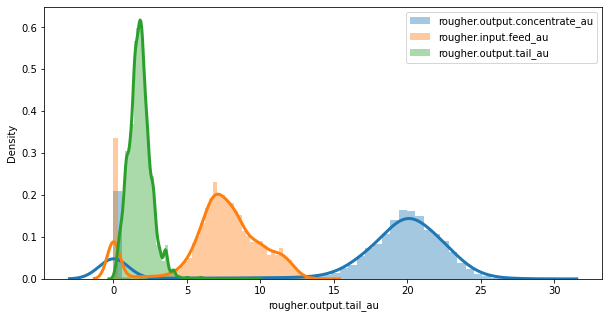

****************************************************************************************************


'df_train, concentrate, feed, tail - semua nilai nol'

16860

1213

0.07194543297746145

****************************************************************************************************


'df_test, concentrate, feed, tail - semua nilai nol'

5856

371

0.06335382513661202

****************************************************************************************************


13488    0.01
16192    0.01
16193    0.01
16194    0.01
16195    0.01
Name: rougher.input.feed_au, dtype: float64

2050     0.0
2045     0.0
2046     0.0
11430    0.0
11429    0.0
Name: rougher.output.concentrate_au, dtype: float64

16788    0.020676
15848    0.024545
16789    0.031234
13093    0.031642
12614    0.049731
Name: rougher.output.tail_au, dtype: float64

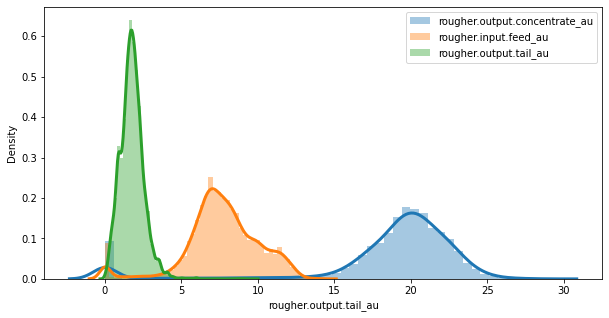

((15647, 87), (15647, 87), (5485, 87), (5485, 87))

In [12]:
# mengecek Outliers for RECOVERY FORMULA

def remove_recovery_outliers(CCol,FCol,TCol):
    
    C = df_train[CCol] 
    F = df_train[FCol]
    T = df_train[TCol]

    draw_displot([C,F,T],[CCol,FCol,TCol],True)

    print(print_separator)
    # mengindetifikasi outliers
    tmp = df_train[((df_train[CCol]<=0.0) & (df_train[TCol]<=0.0) & (df_train[FCol]<=0.0 )) | ((df_train[CCol]<=0.0) & (df_train[FCol]<=0.0))| (df_train[FCol]<=0.0)]
    (tmp[[CCol,FCol,TCol]].sort_values(by=CCol).tail(5))
    display('df_train, concentrate, feed, tail - semua nilai nol',len(df_train),len(tmp),len(tmp)/len(df_train))
    print(print_separator)    
    tmp1 = df_test[((df_test[CCol]<=0.0) & (df_test[TCol]<=0.0) & (df_test[FCol]<=0.0 )) | ((df_test[CCol]<=0.0) & (df_test[FCol]<=0.0 ))| (df_test[FCol]<=0.0)]
    (tmp1[[CCol,FCol,TCol]].sort_values(by=CCol).tail(5))
    display('df_test, concentrate, feed, tail - semua nilai nol',len(df_test),len(tmp1),len(tmp1)/len(df_test))
    print(print_separator)

    # menghilangkan outliers TRAINING DATA
    df_train.drop(tmp.index,inplace=True)
    (len(df_train))

    # menghilangkan outliers TEST DATA
    df_test.drop(tmp1.index,inplace=True)
    (len(df_test))

    C = df_train[CCol] 
    F = df_train[FCol]
    T = df_train[TCol]

    display(F.sort_values().head(5),C.sort_values().head(5),T.sort_values().head(5))

    draw_displot([C,F,T],[CCol,FCol,TCol],True)

remove_recovery_outliers('rougher.output.concentrate_au','rougher.input.feed_au','rougher.output.tail_au')
(df_train.shape,df_all[0].shape,df_test.shape,df_all[1].shape)

**Kesimpulan:**
- Outliers yang dihapus berdasarkan nilai yang digunakan dalam formula recovery untuk Au.
- Semua baris nilai nol untuk roughter.input.feed_au telah dihapus
- Nilai nol sudah berkurang
- Selanjutnya akan diproses outlier berdasarkan IQR.

****************************************************************************************************
df_train
****************************************************************************************************
Konsentrasi:  Semua Logam sebelum menghapus outlier: df_train


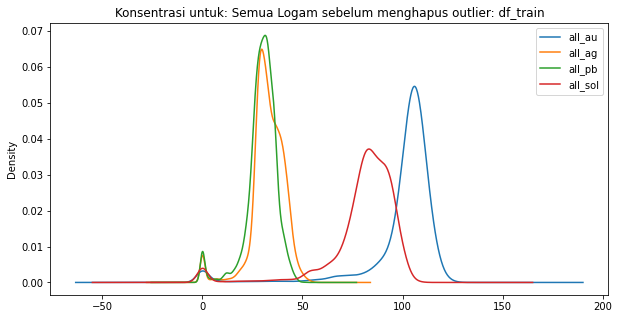

,all_au,all_ag,all_pb,all_sol
count,15647.000000,15647.000000,15647.000000,15647.000000
mean,99.617542,32.690414,29.655686,80.267898
std,20.668182,8.353818,7.684828,18.277003
min,0.040000,0.040000,0.000000,0.000000
25%,99.462553,28.748538,26.660267,76.516229
50%,104.778830,32.685997,30.499147,83.742635
75%,108.926690,38.183440,34.246536,90.989833
max,126.765553,55.959480,51.311488,109.988058


TOTAL OUTLIERS 1507 10.657708628005658 % old Length 15647 new Length 14140
****************************************************************************************************
Konsentrasi:  Semua Logam setelah menghapus outlier: df_train


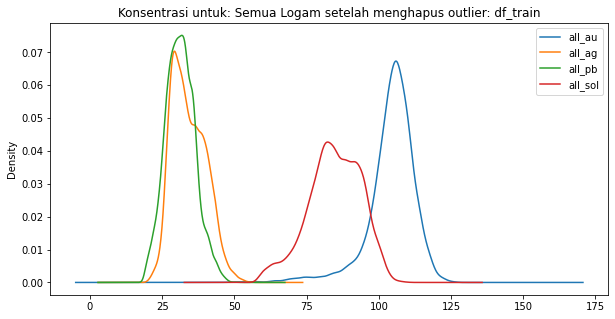

,all_au,all_ag,all_pb,all_sol
count,14140.000000,14140.000000,14140.000000,14140.000000
mean,104.322308,34.202542,31.301094,84.631835
std,8.409908,5.864224,5.065177,9.097962
min,38.968936,20.591841,18.942292,58.441930
25%,101.114828,29.471988,27.704792,78.869834
50%,105.468602,33.359276,31.159760,84.891739
75%,109.295662,38.592288,34.720086,91.606536
max,126.765553,55.959480,51.311488,109.988058


****************************************************************************************************
df_test
****************************************************************************************************
Konsentrasi:  Semua Logam sebelum menghapus outlier: df_test


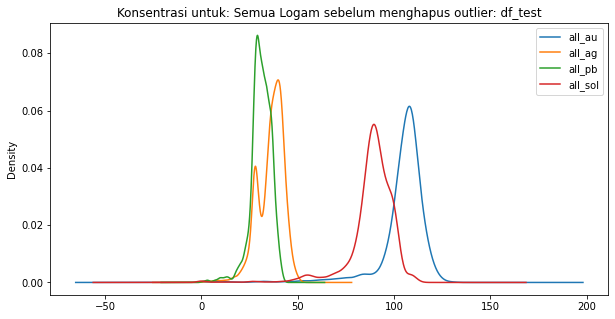

,all_au,all_ag,all_pb,all_sol
count,5485.000000,5485.000000,5485.000000,5485.000000
mean,104.633512,35.997186,30.998666,88.548215
std,12.976520,6.741471,5.300683,12.142315
min,0.568632,0.568441,0.273677,0.000000
25%,102.368431,31.640269,28.251594,85.495959
50%,107.101886,37.260343,31.200758,90.026634
75%,110.778824,40.792309,34.630911,95.312935
max,132.272157,52.189114,42.726320,112.357196


TOTAL OUTLIERS 531 10.718611223253935 % old Length 5485 new Length 4954
****************************************************************************************************
Konsentrasi:  Semua Logam setelah menghapus outlier: df_test


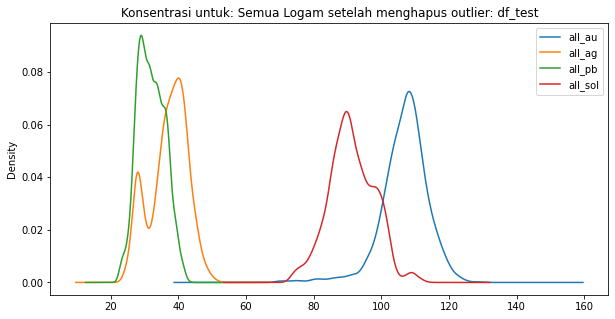

,all_au,all_ag,all_pb,all_sol
count,4954.000000,4954.000000,4954.000000,4954.000000
mean,106.912363,37.055711,31.961170,91.253820
std,6.888216,5.570665,3.967603,6.758906
min,68.963865,23.814398,22.605219,73.026676
25%,103.445791,33.682235,28.835132,86.754382
50%,107.499910,37.895973,31.671882,90.755396
75%,110.932666,41.113666,35.012406,96.044022
max,129.403302,52.189114,42.726320,112.357196


((14140, 87), (14140, 87), (4954, 87), (4954, 87))

In [13]:
# mendapatkan IQR untuk setiap konsentrat dalam dataset
i=0
def process_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    whisker_high = q3+1.5*iqr
    whisker_low  = df_in[col_name].quantile(0.025)
  
    df_outliers = df_in[df_in[col_name] < whisker_low]
    df_out = df_in[df_in[col_name] >= whisker_low]
    (df_outliers[col_name])
    (col_name, ':', len(df_outliers))
    return (len(df_outliers),df_out)

for df in df_all:
    df_name = df_all_names[i]
    print(print_separator)
    print(df_name)
    
    df['all_au'] = df[all_au_list].sum(axis=1)
    df['all_ag'] = df[all_ag_list].sum(axis=1)
    df['all_pb'] = df[all_pb_list].sum(axis=1)
    df['all_sol'] = df[all_sol_list].sum(axis=1)

    concentration_metals('Semua Logam sebelum menghapus outlier: '+df_name,list_all_metals,df)

    tot_outliers=0
    len_train = len(df)
    for col in list_all_metals:
      num_outliers, df= process_outlier(df,col)
      tot_outliers += num_outliers
    newlen_train = len(df)
    print("TOTAL OUTLIERS",tot_outliers,tot_outliers*100/len(df),'%','old Length',len_train,'new Length', newlen_train)
    concentration_metals('Semua Logam setelah menghapus outlier: '+df_name,list_all_metals,df)
    df.drop(list_all_metals,axis=1,inplace=True)
    df_all[i] = df
    i=i+1

df_train=df_all[0]
df_test=df_all[1]
(df_train.shape,df_all[0].shape,df_test.shape,df_all[1].shape)

**Kesimpulan:**
- Terdapat beberapa outlier di ketiga grup yang lebih rendah dari nilai kuantil (0,025).
- Dataset Train dan Test diproses untuk outlier.
- Terdapat sekitar 10% outlier yang dihapus dari dataset Training dan Test.
- Penghapusan outlier mengakibatkan penurunan di grafik "mendekati nilai nol" untuk semua logam.

**1.2. Periksa apakah perolehan emas telah dihitung dengan benar. Menggunakan training set, hitung perolehan untuk fitur rougher.output.recovery. Temukan MAE antara perhitungan Anda dan nilai fitur. Tunjukkan apa yang Anda temukan.**

In [14]:
def calculate_recovery(CCol,FCol,TCol,RCol,NewCol):
    
    C = df_train[CCol]
    F = df_train[FCol]
    T = df_train[TCol]
    R = df_train[RCol]

    FT = F-T
    CT = C-T
    print(print_separator)

    display('F-T head and tail')
    display(FT.sort_values().head(5),FT.sort_values().tail(5))
    print(print_separator)
    display('C-T head and tail')
    display(CT.sort_values().head(5),CT.sort_values().tail(5))
    print(print_separator)

    Recovery = (C * (F-T) ) / (F * (C-T)) * 100
     
    Recovery = np.where(Recovery > 100, 100,Recovery)
    Recovery = np.where(Recovery < 0, 0,Recovery)
    df_train[NewCol] = Recovery

    (df_train[NewCol].head(5))
    (df_train[RCol].head(5))

    (df_train[NewCol].sort_values(ascending=False).tail(5))
    (df_train[RCol].sort_values(ascending=False).tail(5))
    tmp = df_train[NewCol] - df_train[RCol]
      
    draw_displot([R,Recovery,tmp],['Recovery', 'Calc Recovery', 'Difference'],True)
      
    mae_rougher = mean_absolute_error(df_train[RCol],df_train[NewCol])
    print('Recovery MAE', mae_rougher)
    df_train.drop([NewCol], axis=1,inplace=True)

****************************************************************************************************
Rougher.Output.Recovery
****************************************************************************************************


'F-T head and tail'

2491   -0.779612
8627   -0.287160
8945   -0.096808
4615    0.081085
1200    0.081754
dtype: float64

13816    11.336755
15524    11.406383
15512    11.489694
13800    11.527387
15529    11.575835
dtype: float64

****************************************************************************************************


'C-T head and tail'

2073   -2.945371
2391   -2.619551
4791   -2.587677
2074   -2.538689
2392   -2.409091
dtype: float64

3459    24.766039
4162    24.806003
3479    24.996530
3458    25.114919
3476    25.268306
dtype: float64

****************************************************************************************************


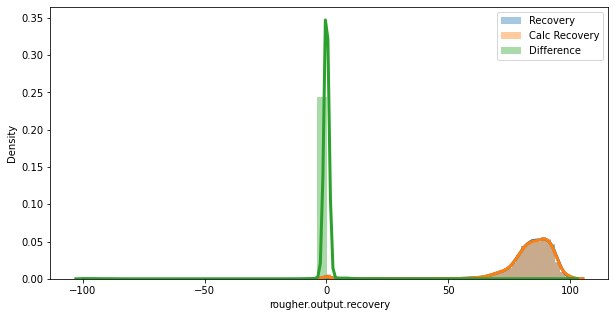

Recovery MAE 0.6242009318823276


In [15]:
print(print_separator)
print('Rougher.Output.Recovery')
calculate_recovery('rougher.output.concentrate_au','rougher.input.feed_au','rougher.output.tail_au','rougher.output.recovery','rougher_recovery')

**Kesimpulan:**
- Nilai Recovery pada 'rougher.output.recovery' memiliki MAE sebesar 0,624.
- Nilai Recovery dihitung menggunakan formula (C * (F-T)) / (F * (C-T))

### Langkah 2
Analisis datanya

**2.1. Buatlah catatan terkait bagaimana konsentrasi logam (Au, Ag, Pb) berubah, tergantung pada tahap pemurniannya.**

****************************************************************************************************
Konsentrasi:  Au


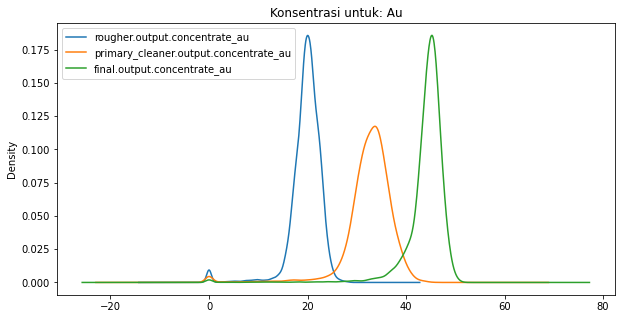

,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,14140.000000,14140.000000,14140.000000
mean,19.699982,32.527867,44.045089
std,3.310684,5.160091,4.460294
min,0.000000,0.000000,0.000000
25%,18.583622,30.796759,43.226830
50%,20.053952,33.134639,44.834521
75%,21.505523,35.248131,46.122671
max,28.522811,45.933934,51.489612


****************************************************************************************************
Konsentrasi:  Ag


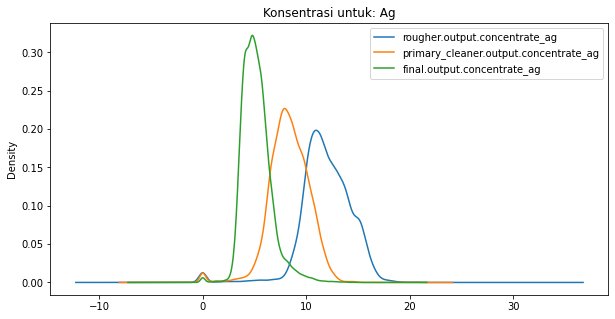

,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
count,14140.000000,14140.000000,14140.000000
mean,11.919735,8.339689,5.213268
std,2.467541,1.917379,1.414378
min,0.000000,0.000000,0.000000
25%,10.568275,7.195724,4.240971
50%,11.839273,8.320055,5.029264
75%,13.498194,9.622168,5.908853
max,24.480271,16.081632,14.419224


****************************************************************************************************
Konsentrasi:  Pb


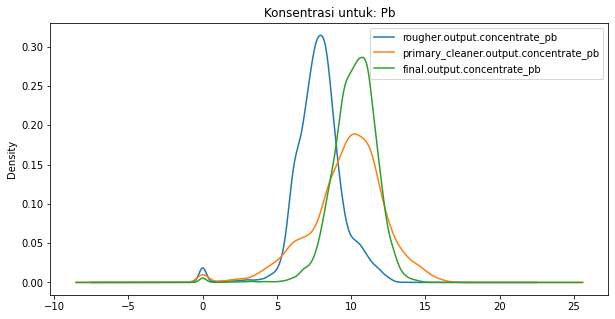

,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
count,14140.000000,14140.000000,14140.000000
mean,7.800710,9.689434,10.209983
std,1.675945,2.556354,1.519482
min,0.000000,0.000000,0.000000
25%,6.945406,8.409460,9.365715
50%,7.823777,9.972849,10.318397
75%,8.656103,11.323105,11.183947
max,14.983547,17.081278,17.031899


In [16]:
df_train.shape,df_all[0].shape,df_test.shape,df_all[1].shape
concentration_metals('Au',concentrate_au_list,df_train)
concentration_metals('Ag',concentrate_ag_list,df_train)
concentration_metals('Pb',concentrate_pb_list,df_train)

rougher.output.concentrate_au            19.699982
rougher.output.concentrate_ag            11.919735
rougher.output.concentrate_pb             7.800710
primary_cleaner.output.concentrate_au    32.527867
primary_cleaner.output.concentrate_ag     8.339689
primary_cleaner.output.concentrate_pb     9.689434
final.output.concentrate_au              44.045089
final.output.concentrate_ag               5.213268
final.output.concentrate_pb              10.209983
dtype: float64

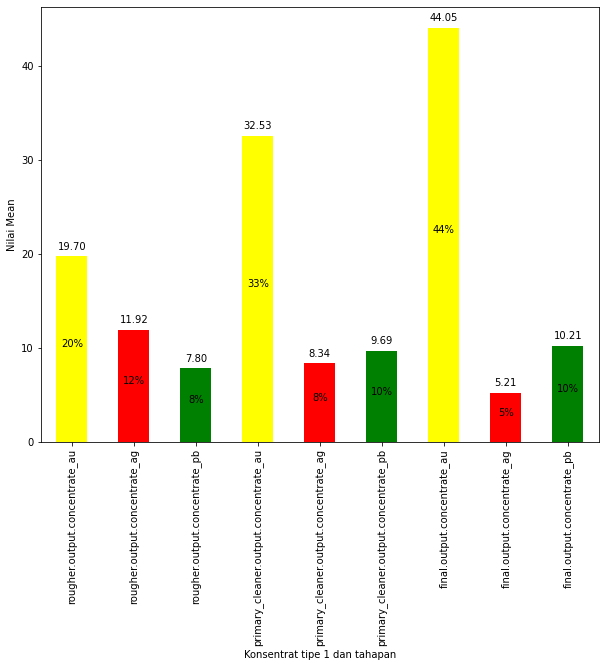

In [17]:
tmp = df_train[concentrate_list].mean()
display(tmp)
ax = tmp.plot.bar(figsize=(10,8),color=['yellow', 'red', 'green'])
ax.set(xlabel='Konsentrat tipe 1 dan tahapan',ylabel='Nilai Mean')
for rec in ax.patches:
    ax.annotate("%.2f" % rec.get_height(), (rec.get_x() + rec.get_width() / 2., rec.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
    height = rec.get_height()
    ax.text(rec.get_x() + rec.get_width() / 2, 
            rec.get_y() + height / 2,
            "{:.0f}%".format(height),
            ha='center', 
            va='bottom')

**Kesimpulan:**

Diagram plot distribusi dan diagram batang menampilkan bahwa:
- Konsentrasi Au meningkat dari Rougher(20%) ke Primary Cleaner(33%) ke Final Output(44%).
- Konsentrasi Ag menurun dari Rougher(12%) ke Primary Cleaner(8%) ke Final Output(5%).
- Konsentrasi Pb meningkat dari Rougher(8%) ke Primary Cleaner(10%) ke Final Output(10%).

**2.2. Bandingkan distribusi ukuran partikel umpan dalam training set maupun dalam test set. 
Jika distribusinya bervariasi secara signifikan, evaluasi model akan salah.**

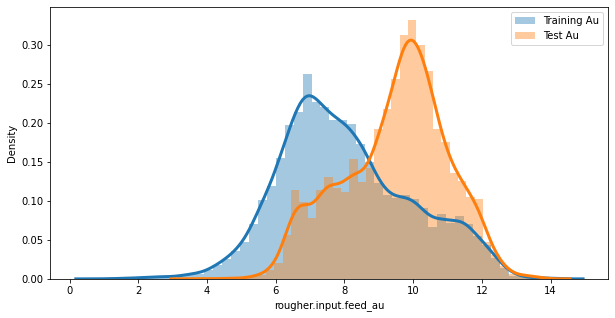

count    14140.000000
mean         8.049369
std          1.920532
min          1.031063
25%          6.697059
50%          7.786654
75%          9.308836
max         14.093363
Name: rougher.input.feed_au, dtype: float64

count    4954.000000
mean        9.468383
std         1.523785
min         3.771721
25%         8.403896
50%         9.685945
75%        10.507913
max        13.731330
Name: rougher.input.feed_au, dtype: float64

In [18]:
(df_train.shape,df_all[0].shape,df_test.shape,df_all[1].shape)
train_au = df_train['rougher.input.feed_au']
test_au = df_test['rougher.input.feed_au']
draw_displot([train_au,test_au],['Training Au','Test Au'],True)
display(train_au.describe(), test_au.describe())

**Kesimpulan:**
- Distribusi feed input serupa dalam dataset Training dan Test.
- Standar Deviasi adalah 1,9 dalam dataset Training dan 1,5 dalam dataset Test.
- Mean, Min, Max sangat dekat dalam dataset Training dan Test. Min sedikit lebih tinggi di Test Dataset. kemungkinan karena memiliki nilai set yang terbatas dan Training set yang jauh lebih besar.

**2.3. Pertimbangkan total konsentrasi semua substansi di tahap yang berbeda: umpan (feed) mentah, konsentrasi yang lebih kasar, dan konsentrasi akhir. Apakah Anda melihat adanya nilai abnormal dalam distribusi total? Jika ya, apakah perlu menghapus nilai-nilai tersebut dari kedua sampel? Jelaskan yang Anda temukan dan singkirkan anomalinya.**

****************************************************************************************************
Training Sample: Konsentrasi Total Semua Substansi Pada Setiap Tahap
****************************************************************************************************
Konsentrasi:  Au


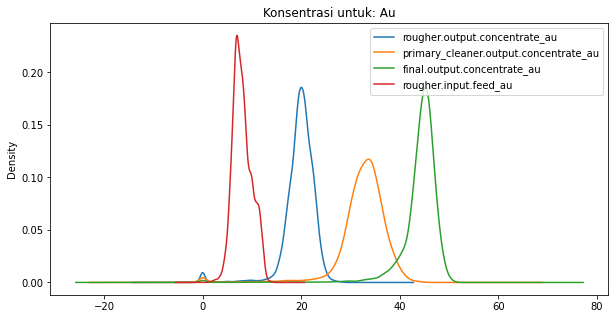

,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au,rougher.input.feed_au
count,14140.000000,14140.000000,14140.000000,14140.000000
mean,19.699982,32.527867,44.045089,8.049369
std,3.310684,5.160091,4.460294,1.920532
min,0.000000,0.000000,0.000000,1.031063
25%,18.583622,30.796759,43.226830,6.697059
50%,20.053952,33.134639,44.834521,7.786654
75%,21.505523,35.248131,46.122671,9.308836
max,28.522811,45.933934,51.489612,14.093363


****************************************************************************************************
Konsentrasi:  Ag


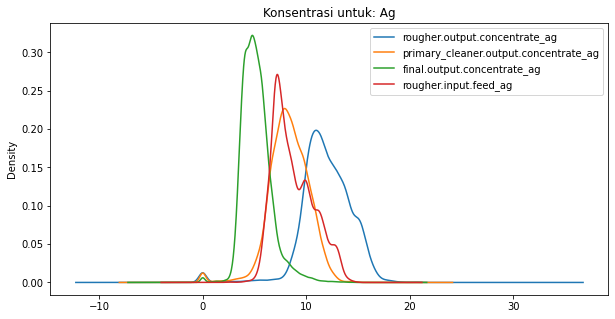

,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag,rougher.input.feed_ag
count,14140.000000,14140.000000,14140.000000,14140.000000
mean,11.919735,8.339689,5.213268,8.729850
std,2.467541,1.917379,1.414378,1.948312
min,0.000000,0.000000,0.000000,2.285306
25%,10.568275,7.195724,4.240971,7.177446
50%,11.839273,8.320055,5.029264,8.286811
75%,13.498194,9.622168,5.908853,10.090947
max,24.480271,16.081632,14.419224,14.869652


****************************************************************************************************
Konsentrasi:  Pb


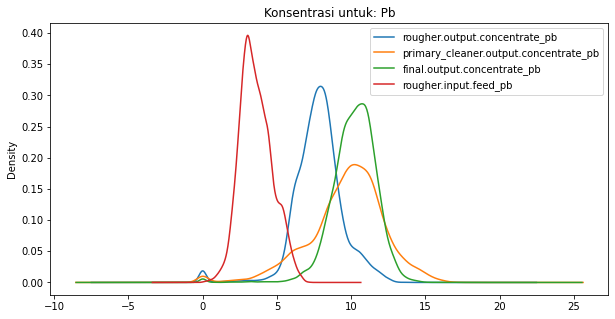

,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb,rougher.input.feed_pb
count,14140.000000,14140.000000,14140.000000,14140.000000
mean,7.800710,9.689434,10.209983,3.600967
std,1.675945,2.556354,1.519482,1.084493
min,0.000000,0.000000,0.000000,0.125889
25%,6.945406,8.409460,9.365715,2.825506
50%,7.823777,9.972849,10.318397,3.476800
75%,8.656103,11.323105,11.183947,4.316275
max,14.983547,17.081278,17.031899,7.142594


****************************************************************************************************
Konsentrasi:  Sol


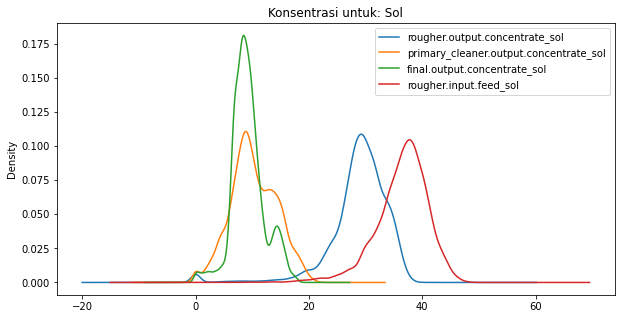

,rougher.output.concentrate_sol,primary_cleaner.output.concentrate_sol,final.output.concentrate_sol,rougher.input.feed_sol
count,14140.000000,14140.000000,14140.000000,14140.000000
mean,28.786305,10.227790,9.220487,36.397253
std,5.436103,4.054761,2.883008,4.626900
min,0.000000,0.000000,0.000000,6.072622
25%,26.979147,7.545104,7.493333,34.027789
50%,29.449003,9.862119,8.916147,36.991799
75%,31.960682,13.226961,10.581034,39.446876
max,40.089993,22.280845,18.124851,48.363177


****************************************************************************************************
Test Sample: Konsentrasi Total Semua Substansi Pada Setiap Tahap
****************************************************************************************************
Konsentrasi:  Au


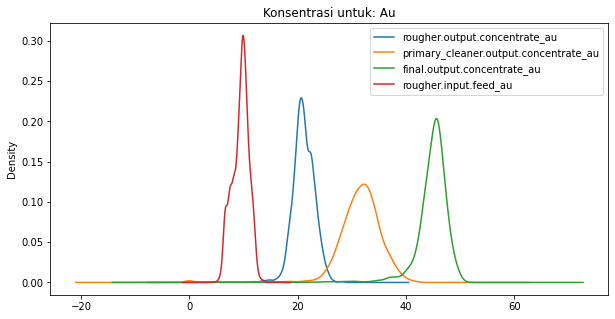

,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au,rougher.input.feed_au
count,4954.000000,4954.000000,4954.000000,4954.000000
mean,21.102639,31.526020,44.815321,9.468383
std,2.043400,4.222424,3.298098,1.523785
min,4.383484,0.000000,7.503352,3.771721
25%,19.964531,29.575288,43.858518,8.403896
50%,21.052179,31.814268,45.343211,9.685945
75%,22.437519,33.915326,46.509781,10.507913
max,28.464601,41.924263,50.985620,13.731330


****************************************************************************************************
Konsentrasi:  Ag


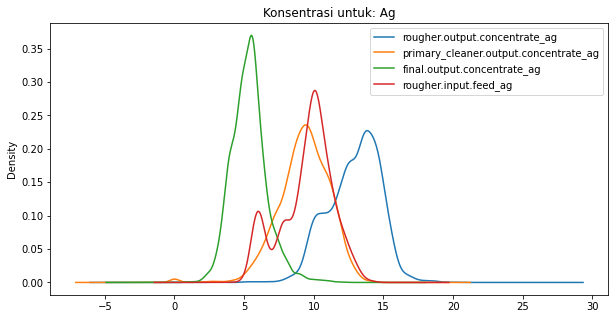

,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag,rougher.input.feed_ag
count,4954.000000,4954.000000,4954.000000,4954.000000
mean,12.902202,9.301810,5.362246,9.489453
std,1.860223,1.823643,1.276827,1.874463
min,2.794246,0.000000,0.818465,3.841710
25%,11.674017,8.248388,4.536248,8.372953
50%,13.141151,9.405995,5.332694,9.855332
75%,14.266718,10.567436,6.026585,10.723263
max,20.483505,14.159305,12.285296,14.406130


****************************************************************************************************
Konsentrasi:  Pb


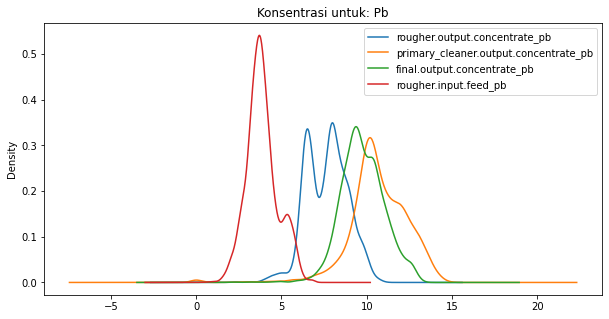

,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb,rougher.input.feed_pb
count,4954.000000,4954.000000,4954.000000,4954.000000
mean,7.653541,10.673893,9.764671,3.869065
std,1.210806,1.729684,1.268121,0.919271
min,1.891460,0.000000,2.123208,0.300816
25%,6.648675,9.823157,8.945253,3.289887
50%,7.772847,10.565885,9.674562,3.770407
75%,8.515719,11.830398,10.573595,4.336422
max,11.025153,14.878122,13.336002,6.905684


****************************************************************************************************
Konsentrasi:  Sol


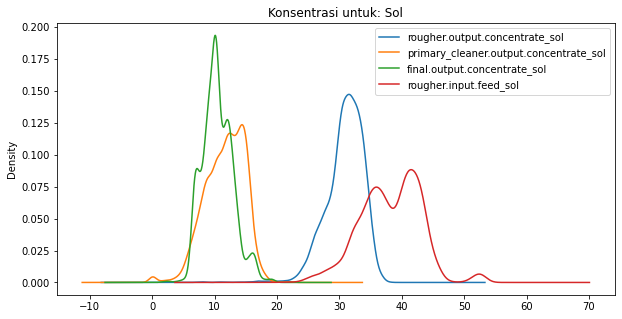

,rougher.output.concentrate_sol,primary_cleaner.output.concentrate_sol,final.output.concentrate_sol,rougher.input.feed_sol
count,4954.000000,4954.000000,4954.000000,4954.000000
mean,30.887097,11.677846,10.476799,38.212078
std,2.994230,3.125663,2.429086,4.854074
min,7.205422,0.000000,1.494074,20.251870
25%,29.362518,9.492486,8.859163,34.907400
50%,31.279445,12.017604,10.266692,38.402650
75%,32.985782,14.139764,12.069910,41.782189
max,37.958347,22.458114,19.615720,53.477742


****************************************************************************************************


In [19]:
# membuat kde plot sesuai parameter

print(print_separator)
print('Training Sample: Konsentrasi Total Semua Substansi Pada Setiap Tahap')
concentration_metals('Au',all_au_list,df_train)
concentration_metals('Ag',all_ag_list,df_train)
concentration_metals('Pb',all_pb_list,df_train)
concentration_metals('Sol',all_sol_list,df_train)
print(print_separator)
print('Test Sample: Konsentrasi Total Semua Substansi Pada Setiap Tahap')
concentration_metals('Au',all_au_list,df_test)
concentration_metals('Ag',all_ag_list,df_test)
concentration_metals('Pb',all_pb_list,df_test)
concentration_metals('Sol',all_sol_list,df_test)
print(print_separator)

**Kesimpulan:**
- Outliers dataset Train dan Test telah diproses sebelumnya. Sehingga terdapat sekitar 10% outlier yang dihapus dari dataset Training dan Test.
- Penghapusan outlier mengakibatkan nilai abnormal di grafik berkurang untuk semua logam.

### Langkah 3
Buat modelnya

**3.1. Ketiklah sebuah fungsi untuk menghitung nilai sMAPE akhir.**

In [20]:
# membuat fungsi untuk menghitung nilai sMAPE akhir

epsilon = 1e-10
def smape_scorer(target: np.ndarray, predicted: np.ndarray):
    
    return np.mean(2.0 * np.abs(target - predicted) / ((np.abs(target) + np.abs(predicted)) + epsilon))

smape_scoring = {'SMAPE': make_scorer(smape_scorer)}

**3.2. Lakukan pelatihan pada model yang berbeda-beda. Evaluasi model-model tersebut menggunakan validasi silang. Pilihlah model terbaik dan uji model tersebut menggunakan sampel tes atau test sample. Tunjukkan apa yang Anda temukan.**

In [21]:
target1 = 'rougher.output.recovery'
target2 = 'final.output.recovery'
targets = [target1,target2]

(df_train.shape,df_all[0].shape,df_test.shape,df_all[1].shape)

df = df_all[0]
df_test = df_all[1]

(np.isnan(df).any())
(np.isnan(df_test).any())

features =  df.drop(targets, axis=1)
target = df[targets]

features_test =  df_test.drop(targets , axis=1)
target_test_rougher = df_test[targets[0]]
target_test_final = df_test[targets[1]]
target_tests = [target_test_rougher,target_test_final]

# standarisasi fitur numerik, semua fitur bersifat numerik
scaler = StandardScaler()

# transform feature set
features = pd.DataFrame(scaler.fit_transform(features),columns = features.columns)
features_test = pd.DataFrame(scaler.fit_transform(features_test),columns = features_test.columns)

# membagi Training menjadi Training(75%) dan validasi_test(25%)
features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)

totsize = len(df)
print(print_separator)
print('training set  : {0:.0%}'.format(len(features_train)/totsize),features_train.shape, ', training target :',target_train.shape)
print('validation set: {0:.0%}'.format(len(features_valid)/totsize),features_valid.shape,', validation target :',target_valid.shape)

target_train_rougher = target_train[targets[0]]
target_train_final = target_train[targets[1]]
target_trains = [target_train_rougher,target_train_final]

target_valid_rougher = target_valid[targets[0]]
target_valid_final = target_valid[targets[1]]
target_valids = [target_valid_rougher,target_valid_final]

****************************************************************************************************
training set  : 75% (10605, 85) , training target : (10605, 2)
validation set: 25% (3535, 85) , validation target : (3535, 2)


In [22]:
# mengevaluasi model yang berbeda

def choose_best_model(feature_train, target_train,feature_valid,target_valid):
    models = list()
    models.append(get_LinearRegression())
    models.append(get_RidgeRegression())
    models.append(get_LassoRegression())
    models.append(get_RandomForestRegression())
    
    for model in models:
        train_model(model, feature_train, target_train)
    
    best_models = []
    for model in models:
        best_models.append(get_best_model(model))
    return min(best_models, key=lambda model:smape_scorer(target_valid,model.predict(feature_valid)))

def get_LinearRegression():
    print('Linear Regression')
    linear = LinearRegression()
    linear_params = {
              "fit_intercept": [True, False],
              "normalize": [True, False],
             }
    grid_result = GridSearchCV(linear, linear_params,scoring=smape_scoring,refit='SMAPE',n_jobs=-1)
    return grid_result

def get_RidgeRegression():
    print('Ridge Regression (Linear)')
    ridge = Ridge(random_state=12345)
    alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    ridge_params = dict(alpha=alpha)
    grid_result = GridSearchCV(ridge, ridge_params,scoring=smape_scoring,refit='SMAPE',n_jobs=-1)
    return grid_result

def get_LassoRegression():
    print('Lasso Regression (Linear)')
    lasso = Lasso(random_state=12345)
    alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    lasso_params = dict(alpha=alpha)
    grid_result = GridSearchCV(lasso, lasso_params,scoring=smape_scoring,refit='SMAPE',n_jobs=-1)
    return grid_result

def get_RandomForestRegression():
    print('RandomForest Regression')
    random_forest = RandomForestRegressor(random_state=12345)
    random_params = {'n_estimators':range(10,50,100),'max_depth': range(2,7)}
    grid_result = GridSearchCV(random_forest, random_params,scoring=smape_scoring,refit='SMAPE',n_jobs=-1)
    return grid_result

def train_model(model, feature_train, target_train):
    model.fit(feature_train, target_train)
    
    print(print_separator)
    print('Model Name: ',model.best_estimator_)
    print('Best Score: ', model.best_score_)
    print('Best Params: ', model.best_params_)
    
def get_best_model(model):
    if not hasattr(model, 'best_estimator_'):
        return model
    return model.best_estimator_

In [23]:
print(print_separator)
print('Mengevaluasi Model untuk:',targets[0])
best_model_rougher = choose_best_model(features_train, target_train_rougher,features_valid,target_valid_rougher)
print(print_separator)
print('Mengevaluasi Model untuk:',targets[1])
best_model_final = choose_best_model(features_train, target_train_final,features_valid,target_valid_final)

****************************************************************************************************
Mengevaluasi Model untuk: rougher.output.recovery
Linear Regression
Ridge Regression (Linear)
Lasso Regression (Linear)
RandomForest Regression
****************************************************************************************************
Model Name:  LinearRegression(fit_intercept=False, normalize=True)
Best Score:  1.8384014989030355
Best Params:  {'fit_intercept': False, 'normalize': True}
****************************************************************************************************
Model Name:  Ridge(alpha=1000, random_state=12345)
Best Score:  0.058762359369602044
Best Params:  {'alpha': 1000}
****************************************************************************************************
Model Name:  Lasso(alpha=10, random_state=12345)
Best Score:  0.09412748373701577
Best Params:  {'alpha': 10}
**********************************************************************

**Kesimpulan:**
- Berbagai model regresi dilatih pada setdata Training dan dievaluasi pada setdata validasi.
- GridSearchCV digunakan untuk menemukan parameter terbaik dan validasi silang.
- Hasil sMAPE untuk masing-masing model dihitung.
- Berdasarkan evaluasi, Ridge Regression menjadi model terbaik untuk kedua target tersebut.

In [24]:
print(print_separator)
print('BEST Model for ', targets[0])
print('Model name:',best_model_rougher)
predicted_test_rougher = best_model_rougher.predict(features_test)
smape_score_rougher = smape_scorer(target_tests[0],predicted_test_rougher)*100
print('sMAPE %age:', smape_score_rougher)
print(print_separator)

print('BEST Model for ', targets[1])
print('Model name:',best_model_final)
predicted_test_final = best_model_final.predict(features_test)
smape_score_final  = smape_scorer(target_tests[1],predicted_test_final)*100
print('sMAPE %age:', smape_score_final)
print(print_separator)

totalSMAPE = .25 * smape_score_rougher + .75 * smape_score_final
print('Skor sMAPE keseluruhan untuk kedua model:',totalSMAPE)

****************************************************************************************************
BEST Model for  rougher.output.recovery
Model name: Ridge(alpha=1000, random_state=12345)
sMAPE %age: 7.8686119555619465
****************************************************************************************************
BEST Model for  final.output.recovery
Model name: Ridge(alpha=1000, random_state=12345)
sMAPE %age: 10.054318312668455
****************************************************************************************************
Skor sMAPE keseluruhan untuk kedua model: 9.507891723391827


**Kesimpulan:**
- Ridge Regression adalah Model Terbaik untuk target rougher.output.recovery dan final.output.recovery
- Skor keseluruhan sMAPE adalah 9,50%